In [1]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
%autoreload 2

In [2]:
# download from wikipedia and reorganization
import os.path
if not os.path.isfile('democracy_index.csv'):
    wikitables = pd.read_html('https://en.wikipedia.org/wiki/Democracy_Index',
                              attrs={"class":"sortable"}, header=0)
    democracy_index = wikitables[0]
    democracy_index.columns = [c.lower().replace(' ', '_') for c in democracy_index.columns]
    democracy_index.rename(columns={'score': 'democracy_index', 
                                    'functioning_ofgovernment': 'functioning_of_government',
                                    'politicalparticipation': 'political_participation',
                                    'politicalculture': 'political_culture',
                                    'civilliberties': 'civil_liberties'}, inplace=True)
    democracy_index.category = democracy_index.category.replace('Flawed democracy[a]', 'Flawed democracy')
    democracy_index = democracy_index[:-1]
    democracy_index.to_csv('democracy_index.csv')
    print('data downloaded from Wikipedia')
else:
    # pre-downloaded file
    democracy_index = pd.read_csv('democracy_index.csv')

In [3]:
category_color = {'Full democracy': 'darkgreen',
                  'Flawed democracy': 'limegreen',
                  'Hybrid regime': 'darkorange',
                  'Authoritarian': 'crimson'}
colors_dict = {c: category_color[dm] for c, dm in zip(democracy_index.country,
                                                      democracy_index.category)}

In [4]:
feature_names = ['democracy_index', 'electoral_processand_pluralism', 'functioning_of_government',
                 'political_participation', 'political_culture', 'civil_liberties']

X = democracy_index[feature_names].values
X = scale(X)

size = 15
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

[[ 2.00265726  1.16078504  1.89080153  2.53899474  2.68165664  1.47733893]
 [ 1.87040657  1.16078504  1.75163545  1.94570167  2.68165664  1.47733893]
 [ 1.78375956  1.0417902   1.89080153  1.64638265  2.68165664  1.36490075]
 ...
 [-1.81893175 -1.53076502 -1.65992155 -1.61940169 -1.49963723 -1.83209148]
 [-1.84629396 -1.67242555 -1.94222988 -1.32008267 -0.73884868 -2.16191014]
 [-2.00590687 -1.67242555 -0.94818647 -1.91337573 -2.64386321 -2.16191014]]
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.03822093702335934
 topographic error: 0.041916167664670656


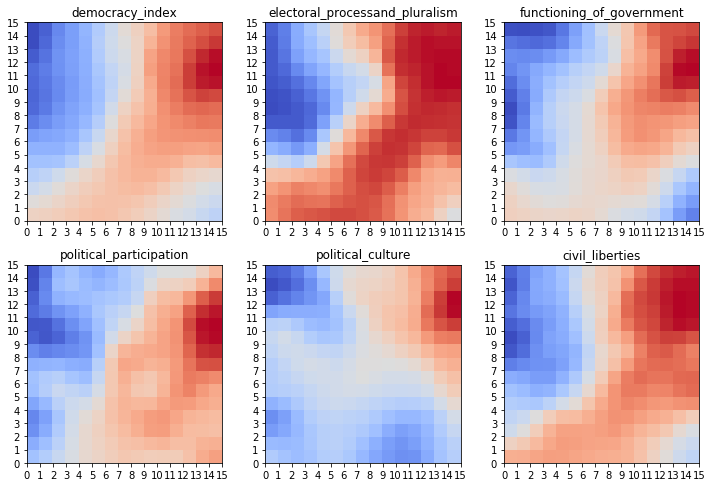

In [5]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()


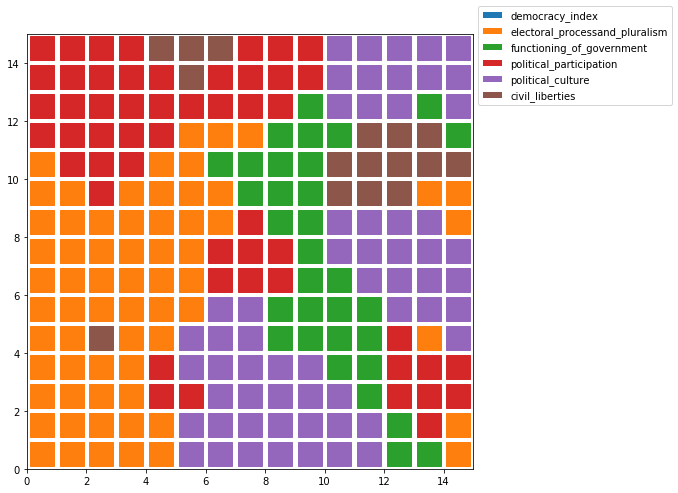

In [6]:
Z = np.zeros((size, size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, size])
plt.ylim([0, size])
plt.show()

In [7]:
def som_feature_selection(W, labels, target_index = 0, a = 0.04):
    """ Performs feature selection based on a self organised map trained with the desired variables

    INPUTS: W = numpy array, the weights of the map (X*Y*N) where X = map's rows, Y = map's columns, N = number of variables
            labels = list, holds the names of the variables in same order as in W
            target_index = int, the position of the target variable in W and labels
            a = float, an arbitary parameter in which the selection depends, values between 0.03 and 0.06 work well

    OUTPUTS: selected_labels = list of strings, holds the names of the selected features in order of selection
             target_name = string, the name of the target variable so that user is sure he gave the correct input
    """


    W_2d = np.reshape(W, (W.shape[0]*W.shape[1], W.shape[2])) #reshapes W into MxN assuming M neurons and N features
    target_name = labels[target_index]


    Rand_feat = np.random.uniform(low=0, high=1, size=(W_2d.shape[0], W_2d.shape[1] - 1)) # create N -1 random features
    W_with_rand = np.concatenate((W_2d,Rand_feat), axis=1) # add them to the N regular ones
    W_normed = (W_with_rand - W_with_rand.min(0)) / W_with_rand.ptp(0) # normalize each feature between 0 and 1

    Target_feat = W_normed[:,target_index] # column of target feature

    # Two conditions to check against a
    Check_matrix1 = abs(np.vstack(Target_feat) - W_normed)
    Check_matrix2 = abs(np.vstack(Target_feat) + W_normed - 1)
    S = np.logical_or(Check_matrix1 <= a, Check_matrix2 <= a).astype(int) # applie "or" element-wise in two matrices

    S[:,target_index] = 0 #ignore the target feature so that it is not picked

    feature_indeces = []
    while True:

        S2 = np.sum(S, axis=0) # add all rows for each column (feature)

        if not np.any(S2 > 0): # if all features add to 0 kill
            break

        selected_feature_index = np.argmax(S2) # feature with the highest sum gets selected first

        if selected_feature_index > (S.shape[1] - (Rand_feat.shape[1] + 1)): # if random feature is selected kill
            break

        feature_indeces.append(selected_feature_index)

        # delete all rows where selected feature evaluates to 1, thus avoid selecting complementary features
        rows_to_delete = np.where(S[:,selected_feature_index] == 1)
        S[rows_to_delete, :] = 0

    selected_labels = [label for i, label in enumerate(labels) if i in feature_indeces]
    return selected_labels, target_name

In [9]:
selected_features, target_name = som_feature_selection(W, feature_names, 0, 0.04)
print("Target variable: {}\nSelected features {}".format(target_name, selected_features))

Target variable: democracy_index
Selected features ['functioning_of_government', 'political_participation', 'civil_liberties']
